In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import astropy
from astropy.io import fits
import astropy.cosmology

import random

from scipy.optimize import fmin_cobyla

import itertools

import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.neighbors import KernelDensity

import warnings
warnings.filterwarnings("ignore")
import emcee

from astroML.datasets import generate_mu_z

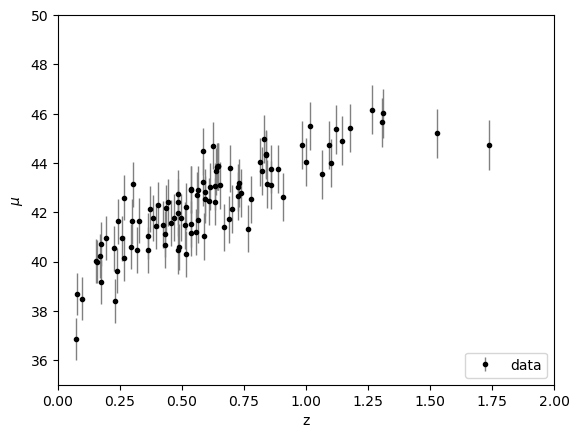

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS
#reshape of data
z_sample=z_sample[:,np.newaxis]
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

In [3]:
x = np.linspace(0, z_sample.max(), 100) #number of Gaussians with which I'm fitting (=they can't be tuned=>need kfold)
x = x[:, np.newaxis] #new format for data

kernel = RBF(1, (0.05, 10.0)) #example of kernel

gp = GaussianProcessRegressor(kernel=kernel, alpha=(dmu)**2, random_state=None, normalize_y=True,optimizer=None)
gp.fit(z_sample, mu_sample)
f, f_err = gp.predict(x, return_std=True)

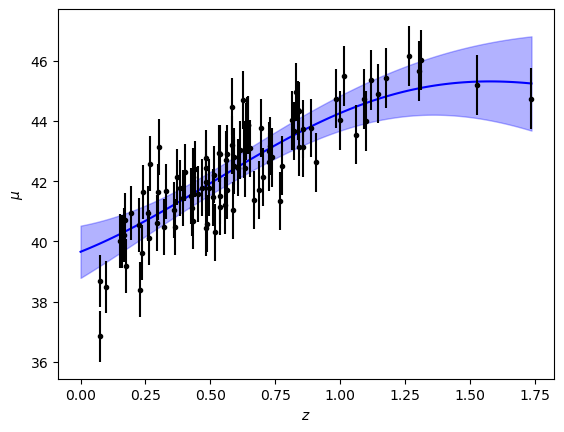

In [4]:
#plot of data and fit with band
fig = plt.figure()
ax= fig.add_subplot()

#plot of fit
ax.plot(x, f, '-', color='blue')
#plot of error band (at 2 sigmas)
ax.fill_between(x.flatten(), f - 2 * f_err, f + 2 * f_err, color='blue', alpha=0.3)
#plot of data
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k')

ax.set_xlabel('$z$')
ax.set_ylabel('$\mu$')
plt.show()

In [5]:
#cross validation on kernel

#dividing sample in training and test
x_c = z_sample[:,np.newaxis]
y_c = mu_sample
dy_c = dmu

x_train, x_validation, ydy_train, ydy_validation = train_test_split(x_c, np.array([y_c,dy_c]).T, test_size=0.3, random_state=42)
y_train,dy_train = ydy_train.T
y_validation,dy_validation = ydy_validation.T

#reshape of the data
x_train=(x_train.reshape(-1,1))
x_validation=(x_validation.reshape(-1,1))

Kernel dimention= 0.6 0.9776263006126577 0.8325307557664197
Kernel dimention= 0.6206896551724138 0.9780300862261818 0.8325006778156276
Kernel dimention= 0.6413793103448275 0.978266842568555 0.832238953541641
Kernel dimention= 0.6620689655172414 0.9783942887019264 0.8317886138952919
Kernel dimention= 0.6827586206896552 0.9784657209891179 0.8311934003811543
Kernel dimention= 0.7034482758620689 0.97852866705322 0.8304958282968665
Kernel dimention= 0.7241379310344828 0.9786242854354397 0.8297358989417618
Kernel dimention= 0.7448275862068965 0.9787872552081588 0.8289502963538933
Kernel dimention= 0.7655172413793103 0.9790459785491301 0.8281719405666172
Kernel dimention= 0.7862068965517242 0.9794229760970119 0.8274297995556077
Kernel dimention= 0.8068965517241379 0.9799353936494151 0.8267488853805182
Kernel dimention= 0.8275862068965517 0.980595564777985 0.826150377899081
Kernel dimention= 0.8482758620689654 0.98141159159421 0.8256518332985006
Kernel dimention= 0.8689655172413793 0.982387918

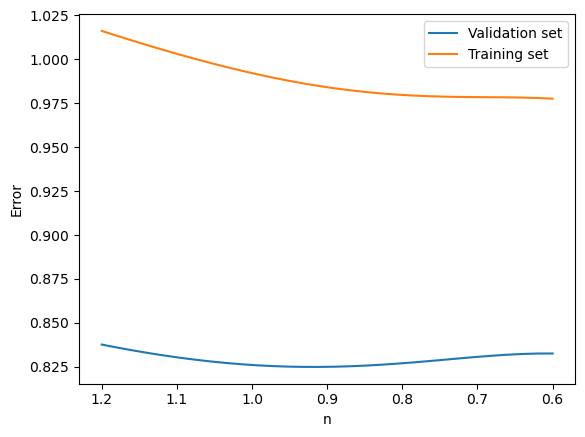

In [6]:
#range for which I test kernel wicth
kernel_range = np.linspace(0.6,1.2,30) #in small value of lenght => goes in overfit

err_train, err_test= [], []
for k in kernel_range:
    kernel = RBF(length_scale=k, length_scale_bounds=(0.05, 10.0))

    classifier = GaussianProcessRegressor(kernel=kernel, alpha=(dy_train)**2, random_state=None, normalize_y=True,optimizer=None)
    classifier.fit(x_train, y_train)
    error_train = np.sqrt( np.sum((y_train-classifier.predict(x_train) )**2) / len(x_train) )
    error_validation = np.sqrt( np.sum((y_validation-classifier.predict(x_validation) )**2) / len(x_validation) )

    #value of error in train and test
    print("Kernel dimention=",k, error_train, error_validation)
    err_train.append(error_train)
    err_test.append(error_validation)

plt.plot(kernel_range,err_test, label='Validation set')
plt.plot(kernel_range,err_train, label='Training set')

plt.xlabel('n')
plt.gca().invert_xaxis()
plt.ylabel('Error')
plt.legend()

#find the best value of kernel from minimum of test
best_kern_lenght=kernel_range[np.argmin(err_test)]
print("Best", best_kern_lenght, min(err_test))

plt.show()

In [7]:
x_grid_best = (np.linspace(0, z_sample.max(), 100))[:, np.newaxis] #grid for plot

kernel_best = RBF(best_kern_lenght, (0.02, 100)) #best kernel cross validated

gp_best = GaussianProcessRegressor(kernel=kernel_best, alpha=(dy_train)**2, random_state=None, normalize_y=True,optimizer=None)
gp_best.fit(x_train, y_train)
f_best, f_err_best = gp_best.predict(x_grid_best, return_std=True) #predict value of fit

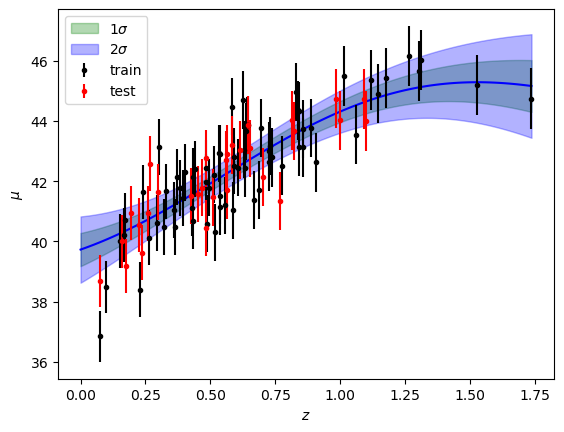

In [8]:
fig = plt.figure()
ax= fig.add_subplot()

ax.plot(x_grid_best, f_best, '-', color='blue')
ax.fill_between(x_grid_best.flatten(), f_best - 1 * f_err_best, f_best + 1 * f_err_best, color='green', alpha=0.3, label='1$\sigma$')
ax.fill_between(x_grid_best.flatten(), f_best - 2 * f_err_best, f_best + 2 * f_err_best, color='blue', alpha=0.3, label='2$\sigma$')
ax.errorbar(x_train, y_train, dy_train, fmt='.k', label='train')
ax.errorbar(x_validation, y_validation, dy_validation, fmt='.r', label='test')

ax.set_xlabel('$z$')
ax.set_ylabel('$\mu$')
plt.legend()
plt.show()

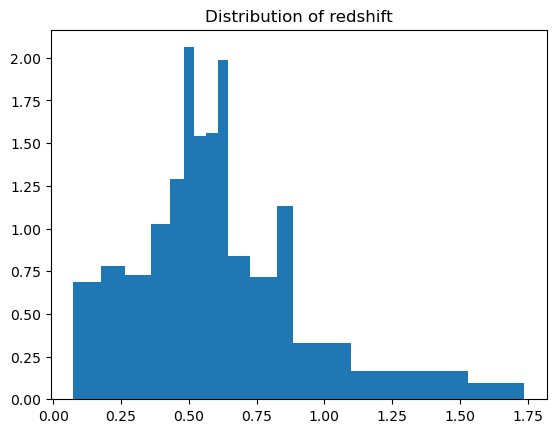

In [9]:
#to find new data => density distribution of z data => new values => predict mu values on these new z
z_kde=(z_sample[:,0])[:, np.newaxis] #reshape of data for kde

N_bins_z=7
bins_set_z=np.append(np.sort(z_sample[:,0])[::N_bins_z], np.max(z_sample[:,0]))

data_z=plt.hist(z_sample[:,0], bins=bins_set_z, density=True)
plt.title('Distribution of redshift')
plt.show()

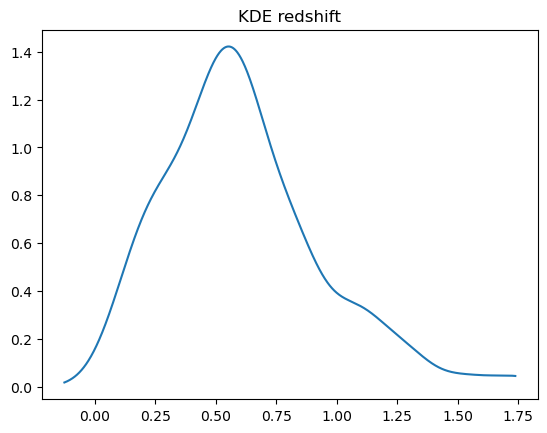

In [10]:
#kde for z
kde_z = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(z_kde)
xgrid_z=(np.linspace(z_sample.min()-0.2,z_sample.max(),1000))
ygrid_z = np.exp(kde_z.score_samples((xgrid_z)[:,np.newaxis])) #score in log => exp

plt.plot(xgrid_z,ygrid_z)
plt.title('KDE redshift')
plt.show()

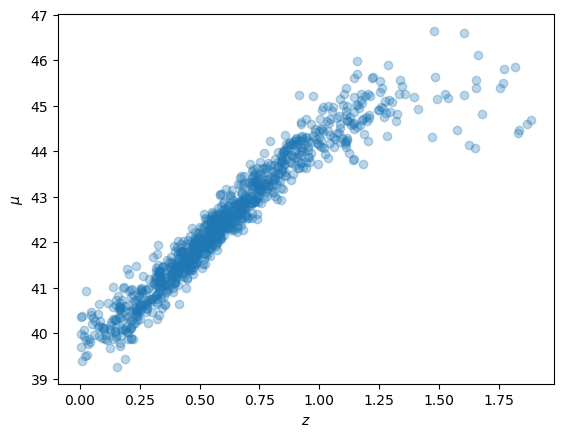

In [11]:
z_new=kde_z.sample(1000) #new sample of z
z_new_b0=z_new[z_new>0].reshape(-1,1)
mu_predict_new, sigma_new =gp_best.predict(z_new_b0, return_std=True) 
mu_new= np.random.normal(loc=mu_predict_new, scale=sigma_new) #new sample of mu for z>0 

plt.scatter(z_new_b0,mu_new, alpha=0.3)
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.show()

In [12]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) #retake the data to avoid error in shape

In [13]:
#mcmc to fit the complex model with DM

#model
def distance_model(z, H0, OmegaM):
    cosmology_model = astropy.cosmology.LambdaCDM(H0=H0, Om0=OmegaM, Ode0=1-OmegaM) #parameters: H0, omega matter, omega dark energy
    return cosmology_model.distmod(z).value #.value for not unit in astropy

#likelihood
def LogLikelihood(par): #better log scale
    H0, OmegaM = par
    if OmegaM<0: #omega matter always bigger than 0, H0 doesn't have any constrains
        return -np.inf
    else:
        mod_mu = distance_model(z_sample, H0, OmegaM)
    return -0.5*np.sum(((np.array(mu_sample)-mod_mu)/dmu)**2)

#prior
def LogPrior(par):
    H0, OmegaM = par
    if ((50<H0<100) and (0.1<OmegaM<1)): #if parameters in interval => correct
        return 0
    else:
        return -np.inf
    
#posterior = prior * likelihood
def LogPosterior(par):
    return LogLikelihood(par)+LogPrior(par)

In [14]:
ndim = 2 #number of parameters = number of dimentions
nwalkers = 5 #number of walkers
nsteps = 10000 #n of steps of the chain

#initialize parameters 
np.random.seed(0)
init=np.array([72, 0.4]) 
starting_guesses = init+1e-1*np.random.randn(nwalkers, ndim) #important to add a little variation for walker

#function for the emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps)
print("done")

done


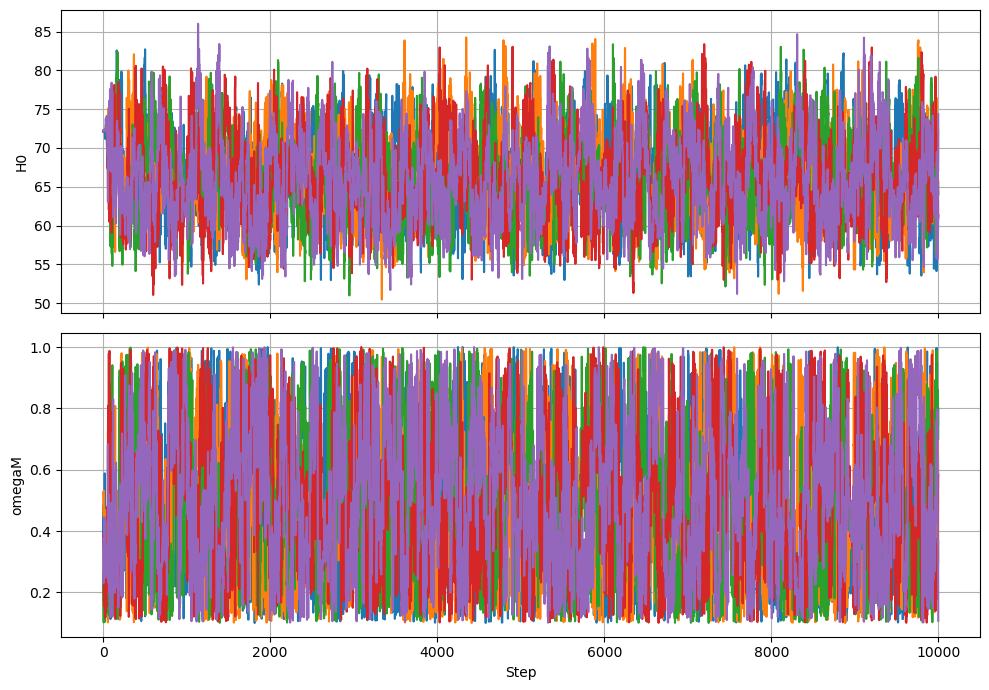

In [15]:
#take each chain
chain_all = sampler.get_chain()

#Plotting each parameter's chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["H0", "omegaM"]  #Parameters

for i in range(ndim):
    ax = axes[i]
    ax.plot(chain_all[:,:, i])  #Plot chain for each walker
    ax.set_ylabel(labels[i])
    ax.grid()

axes[-1].set_xlabel("Step")
plt.tight_layout()
plt.show()

[39.85441904 40.75035008]


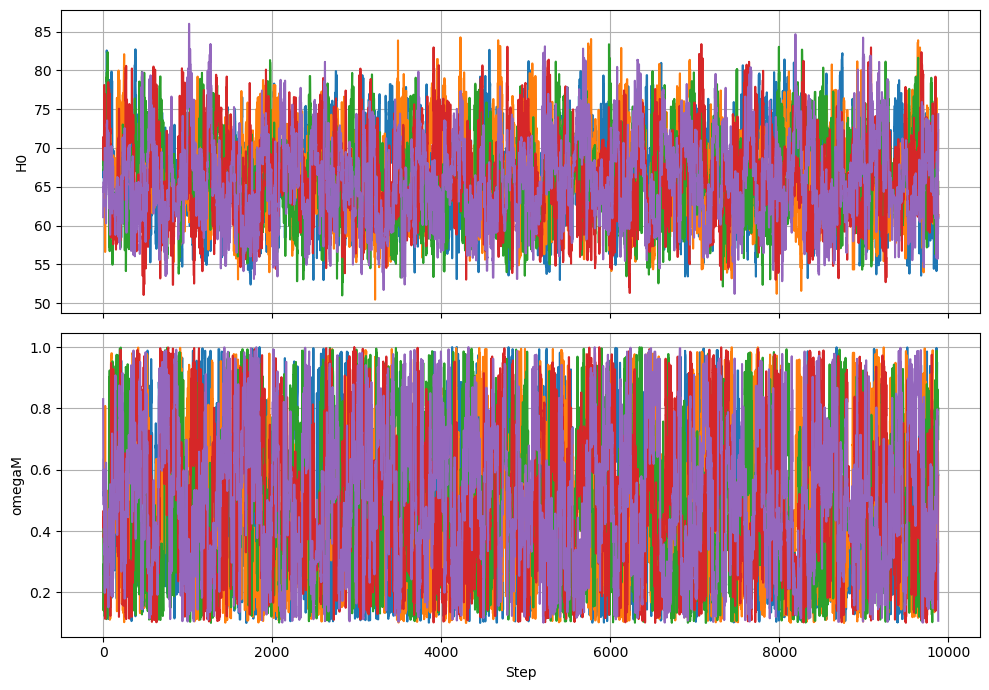

In [16]:
#take each chain post burn in
tau=sampler.get_autocorr_time(tol=0)
print(tau)
thin=int(np.max(tau))
burned=3*int(np.max(tau))

chain_notBurned = sampler.get_chain(discard=burned)

#Plotting each parameter's chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(chain_notBurned[:,:, i])  #Plot chain for each walker
    ax.set_ylabel(labels[i])
    ax.grid()

axes[-1].set_xlabel("Step")
plt.tight_layout()
plt.show()

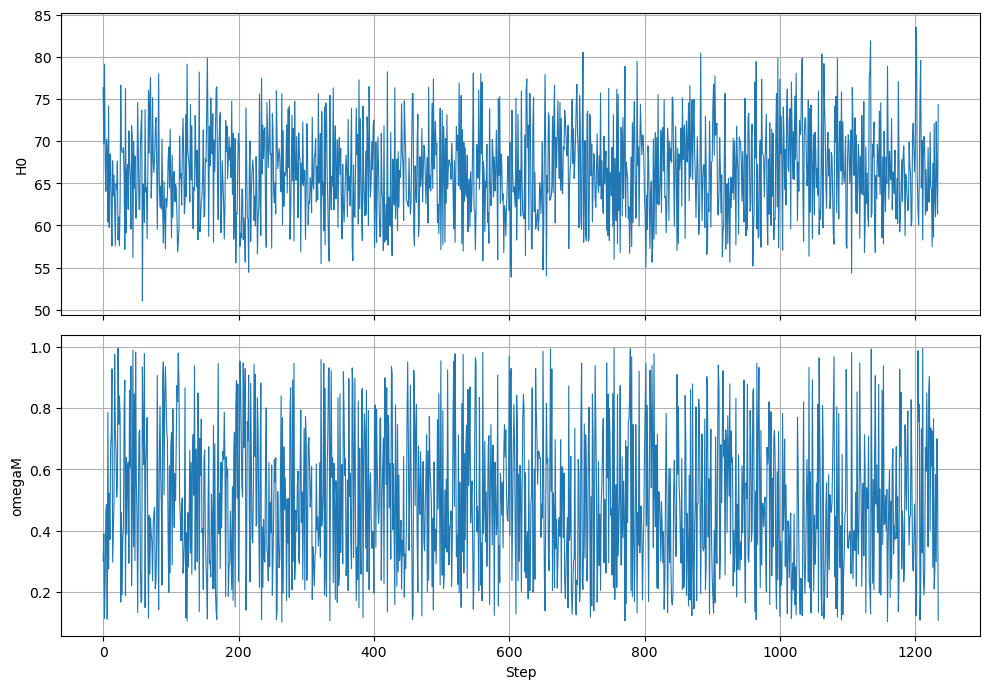

In [17]:
#take each chain post burn in and thinned + flatted
flat_chain=sampler.get_chain(discard=burned, thin=thin, flat=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot((flat_chain[:, i]), lw=0.8) #plot the flatten chain for all parameters
    ax.set_ylabel(labels[i])
    ax.grid()

axes[-1].set_xlabel("Step")
plt.tight_layout()
plt.show()

In [18]:
means=[]
err=[]
for i in range(ndim):
    means.append(np.mean(flat_chain[:,i]))
    err.append(np.percentile(flat_chain[:,i], 16))
    print(labels[i],': ',means[i], '+-', err[i]) 

H0 :  66.35426703748708 +- 60.41233324825836
omegaM :  0.49288984329175317 +- 0.22605458130659853


In [19]:
#median values of the parameters and errors
medians = []
lower_err = []
upper_err = []

for i in range(ndim):
    param_samples = flat_chain[:, i]
    median_val = np.median(param_samples)
    low = np.percentile(param_samples, 16)
    high = np.percentile(param_samples, 84)

    medians.append(median_val)
    lower_err.append(median_val - low)
    upper_err.append(high - median_val)
    
    print(f"{labels[i]}: {medians[i]:.3f} -{lower_err[i]:.3f}/+{upper_err[i]:.3f}")

H0: 66.240 -5.827/+5.887
omegaM: 0.471 -0.244/+0.299


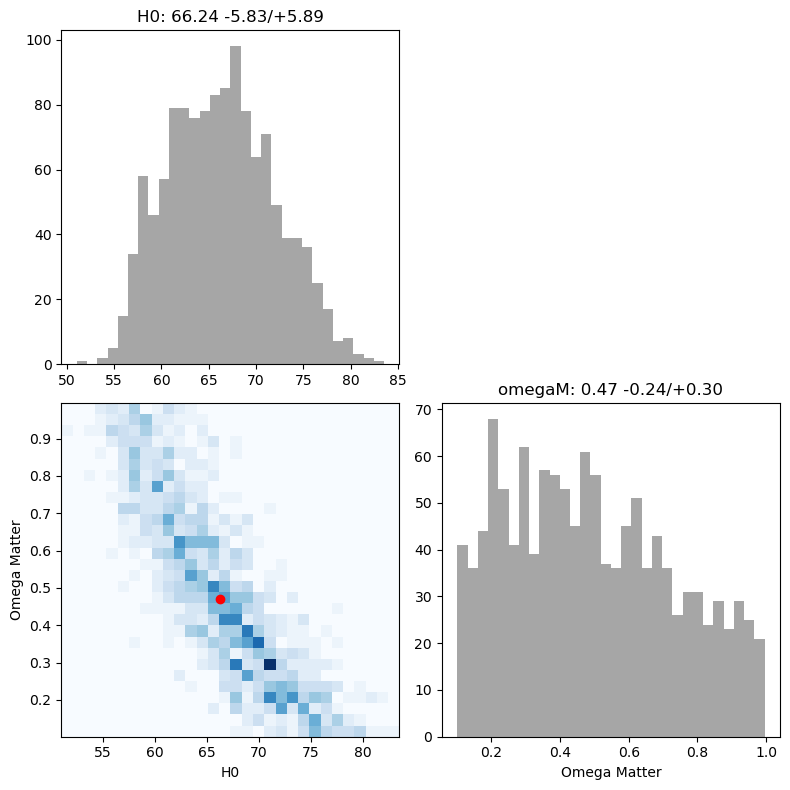

In [20]:
# Chain data
data = sampler.get_chain(discard=burned, thin=thin, flat=True)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Plot histograms and scatter plot
axes[0][0].hist(data[:, 0], bins=30, color='gray', alpha=0.7)
axes[0][0].set_title(f"{labels[0]}: {medians[0]:.2f} -{lower_err[0]:.2f}/+{upper_err[0]:.2f}")
axes[0][1].axis("off")
axes[1][0].hist2d(data[:, 0], data[:, 1], bins=30, cmap='Blues')
axes[1][0].scatter(medians[0],medians[1], c='red')
axes[1][0].set_xlabel('H0')
axes[1][0].set_ylabel('Omega Matter')
axes[1][1].hist(data[:, 1], bins=30, color='gray', alpha=0.7)
axes[1][1].set_title(f"{labels[1]}: {medians[1]:.2f} -{lower_err[1]:.2f}/+{upper_err[1]:.2f}")
axes[1][1].set_xlabel('Omega Matter')

plt.tight_layout()
plt.show()

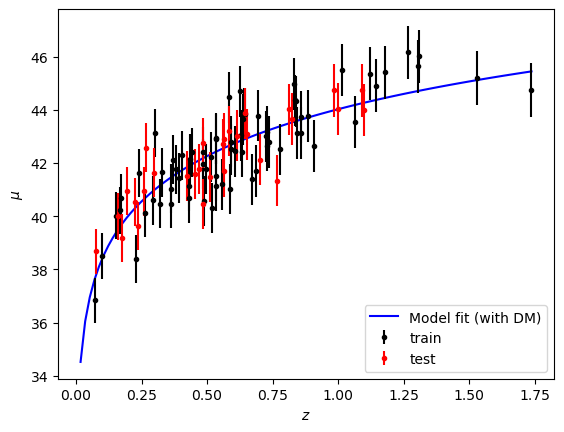

In [21]:
#Plot of the fit with the real model with DM
fig = plt.figure()
ax= fig.add_subplot()

ax.plot(x_grid_best, distance_model(x_grid_best, medians[0], medians[1]), '-', color='blue', label='Model fit (with DM)')
ax.errorbar(x_train, y_train, dy_train, fmt='.k', label='train')
ax.errorbar(x_validation, y_validation, dy_validation, fmt='.r', label='test')

ax.set_xlabel('$z$')
ax.set_ylabel('$\mu$')
plt.legend(loc='lower right')
plt.show()

In [22]:
#MCMC with model without DM

#model
def distance_model_2(z, H0): #don't have omegaM has parameter => set to 1
    cosmology_model = astropy.cosmology.LambdaCDM(H0=H0, Om0=1, Ode0=0) #parameters: H0, omega matter, omega dark energy
    return cosmology_model.distmod(z).value #.value for not unit in astropy

#likelihood
def LogLikelihood_2(par): #better log scale
    H0 = par[0] #no contrains on H0
    mod_mu = distance_model_2(z_sample, H0)
    return -0.5*np.sum(((np.array(mu_sample)-mod_mu)/dmu)**2)

#prior
def LogPrior_2(par):
    H0 = par[0]
    if (50<H0<100): #if parameters in interval => correct
        return 0
    else:
        return -np.inf
    
#posterior = prior * likelihood
def LogPosterior_2(par):
    return LogLikelihood_2(par)+LogPrior_2(par)

In [23]:
ndim_2 = 1 #number of parameters = number of dimention
nwalkers_2 = 3 #number of walkers
nsteps_2 = 10000 #n of steps of the chain

#initialize parameters 
np.random.seed(0)
init_2=np.array([72]) 
starting_guesses_2 = 72+1e-1*np.random.randn(nwalkers_2, ndim_2) #important to add a little variation for walker

#function for the emcee
sampler_2 = emcee.EnsembleSampler(nwalkers_2, ndim_2, LogPosterior_2)
sampler_2.run_mcmc(starting_guesses_2, nsteps_2)
print("done")

done


[34.423859]


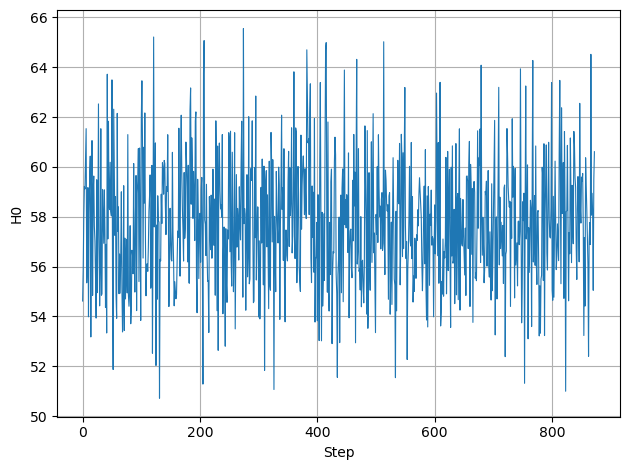

In [24]:
#take each chain post burn in + thinned and flattened
tau_2=sampler_2.get_autocorr_time(tol=0)
print(tau_2)
thin_2=int(np.max(tau_2))
burned_2=3*int(np.max(tau_2))

flat_chain_2 = sampler_2.get_chain(discard=burned_2, thin=thin_2, flat=True)

fig, axes = plt.subplots(ndim_2)

axes.plot((flat_chain_2[:, 0]), lw=0.8) #plot the flatten chain for all parameters
axes.set_ylabel('H0')
axes.grid()

axes.set_xlabel("Step")
plt.tight_layout()
plt.show()

In [25]:
#median values of the parameters and errors
medians_2 = []
lower_err_2 = []
upper_err_2 = []

for i in range(ndim_2):
    param_samples_2 = flat_chain_2[:, i]
    median_val_2 = np.median(param_samples_2)
    low_2 = np.percentile(param_samples_2, 16)
    high_2 = np.percentile(param_samples_2, 84)

    medians_2.append(median_val_2)
    lower_err_2.append(median_val_2 - low_2)
    upper_err_2.append(high_2 - median_val_2)
    
    print(f"{labels[i]}: {medians_2[i]:.3f} -{lower_err_2[i]:.3f}/+{upper_err_2[i]:.3f}")

H0: 57.662 -2.480/+2.535


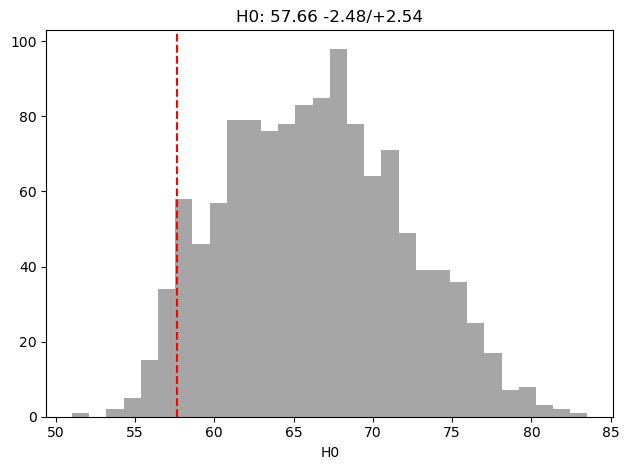

In [26]:
# Chain data
data_2 = sampler_2.get_chain(discard=burned_2, thin=thin_2, flat=True)

# Create subplots
fig, axes = plt.subplots(1)

# Plot histogram
axes.hist(data[:,0], bins=30, color='grey', alpha=0.7)
axes.set_title(f"{labels[0]}: {medians_2[0]:.2f} -{lower_err_2[0]:.2f}/+{upper_err_2[0]:.2f}")
axes.set_xlabel('H0')
axes.axvline(medians_2[0], color="red", linestyle="--")
plt.tight_layout()
plt.show()

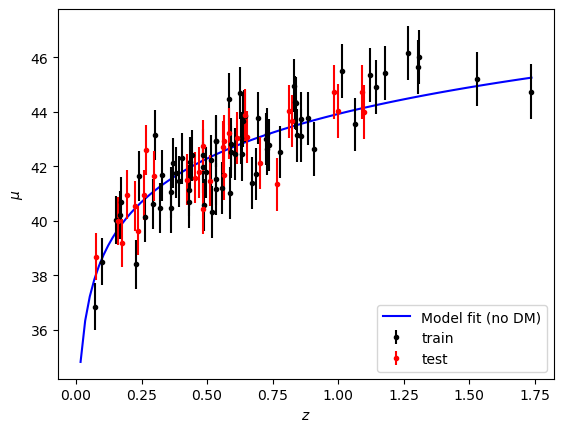

In [27]:
#Plot of the fit with the model without DM
fig = plt.figure()
ax= fig.add_subplot()

ax.plot(x_grid_best, distance_model_2(x_grid_best, medians_2[0]), '-', color='blue', label='Model fit (no DM)')
ax.errorbar(x_train, y_train, dy_train, fmt='.k', label='train')
ax.errorbar(x_validation, y_validation, dy_validation, fmt='.r', label='test')

ax.set_xlabel('$z$')
ax.set_ylabel('$\mu$')
plt.legend(loc='lower right')
plt.show()

In [28]:
#comparing the model with DM with one with only matter using Product space sampler

#model
def distance_model_PSS(z, H0, OmegaM, model_id):
    if model_id == 0: #first model => with DM
        return astropy.cosmology.LambdaCDM(H0=H0, Om0=OmegaM, Ode0=1-OmegaM).distmod(z).value
    elif model_id == 1: #second model => without DM
        return astropy.cosmology.wCDM(H0=H0, Om0=1, Ode0=0, w0=0).distmod(z).value

#prior
def LogPrior_PSS(H0, OmegaM, model_id):
    if (50 < H0 < 100) and (0.1 < OmegaM < 1) and (model_id in [0, 1]):
        return 0
    else:
        return -np.inf

#Likelihood
def LogLikelihood_PSS(H0, OmegaM, model_id):
    if OmegaM<0 or model_id not in [0, 1]: #omega matter always bigger than 0, H0 doesn't have any constrains, but constrain on n model
        return -np.inf
    else:
        if model_id == 0:
            mod_mu = distance_model_PSS(z_sample, H0, OmegaM, model_id=0)
            #gauss around parameter space H0, OmegaM and also around value of model
            return -0.5*np.sum(((np.array(mu_sample)-mod_mu)/dmu)**2)+ (-50 *((model_id - round(model_id))**2)) 
        
        if model_id == 1:
            mod_mu = distance_model_PSS(z_sample, H0, OmegaM, model_id=1)
            return -0.5 * np.sum(((mu_sample - mod_mu)/dmu)**2) + (-50 * ((model_id - round(model_id))**2))

#posterior
def LogPosterior_PSS(theta):
    H0, OmegaM, model_id = theta
    model_id = int(round(model_id))# force to 0 or 1
    
    return LogLikelihood_PSS(H0, OmegaM, model_id)+LogPrior_PSS(H0, OmegaM, model_id)

In [29]:
ndim_PSS = 3 #number of parameters = number of dimention
nwalkers_PSS = 7 #number of walkers
nsteps_PSS = 10000 #n of steps of the chain

#initialize parameters 
np.random.seed(0)
init_PSS=np.array([72, 0.4, 0]) 
starting_guesses_PSS = init_PSS+1e-1*np.random.randn(nwalkers_PSS, ndim_PSS) #important to add a little variation for walker

#function for the mcmc
sampler_PSS = emcee.EnsembleSampler(nwalkers_PSS, ndim_PSS, LogPosterior_PSS)
sampler_PSS.run_mcmc(starting_guesses_PSS, nsteps_PSS)
print("done")

done


In [30]:
tau_PSS=sampler_PSS.get_autocorr_time(tol=0)
thin_PSS=int(np.max(tau_PSS))
burned_PSS=3*int(np.max(tau_PSS))

samples_PSS = sampler_PSS.get_chain(discard=burned_PSS, thin=thin_PSS, flat=True)
model_ids = np.round(samples_PSS[:, 2]).astype(int)
model_probs = np.bincount(model_ids) / len(model_ids)
print("Posterior model probabilities:", model_probs)
print('Ratio model DM/ model noDM: ', model_probs[0]/model_probs[1])

Posterior model probabilities: [0.65142857 0.34857143]
Ratio model DM/ model noDM:  1.8688524590163935
